Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:36:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Hyperparameters:
{'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 15, 'xgb__n_estimators': 350, 'xgb__subsample': 1.0}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      3738
           1       0.88      0.95      0.91      9432
           2       0.89      0.84      0.87      4251

    accuracy                           0.89     17421
   macro avg       0.90      0.87      0.88     17421
weighted avg       0.89      0.89      0.89     17421


Accuracy (Test Set): 0.8929


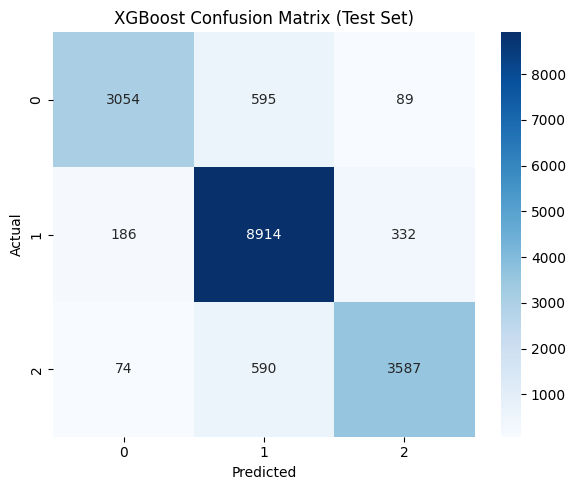

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# === Load and prepare data ===
df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
df_sensor['playYears'] = df_sensor['playYears'].astype(int)

X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']
classes = np.unique(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        objective='multi:softprob',  
        eval_metric='mlogloss',
        use_label_encoder=False,
        num_class=3,
        random_state=42,
        n_jobs=-1
    ))
])


param_grid = {
    'xgb__n_estimators': [150, 250, 350],
    'xgb__max_depth': [6, 10, 15],
    'xgb__learning_rate': [0.1, 0.3, 0.5],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}


grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro', 
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("\nBest Hyperparameters:")
print(grid.best_params_)

best_model = grid.best_estimator_
probs = best_model.predict_proba(X_test)
y_pred = np.argmax(probs, axis=1)

# === Evaluation ===
print("\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy (Test Set): {accuracy:.4f}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("XGBoost Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\pi

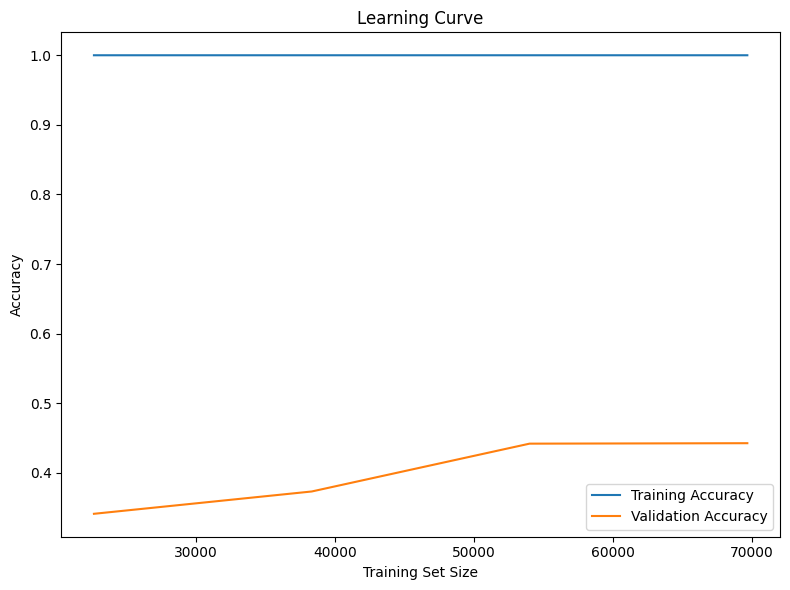

In [24]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='accuracy', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.tight_layout()
plt.show()


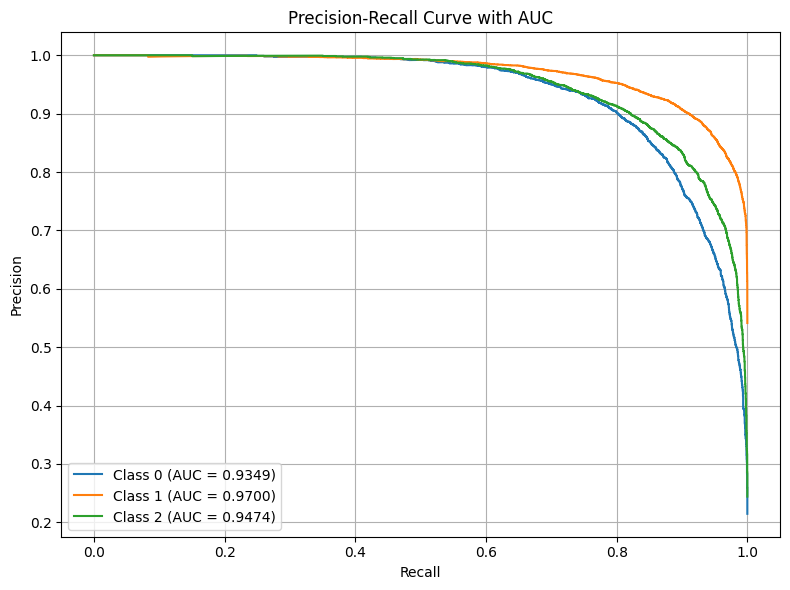

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)


probs = best_model.predict_proba(X_test)

auc_scores = []


plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], probs[:, i])
    auc_score = average_precision_score(y_test_bin[:, i], probs[:, i])
    auc_scores.append(auc_score)
    plt.plot(recall, precision, label=f'Class {classes[i]} (AUC = {auc_score:.4f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with AUC")
plt.legend(loc='lower left')
plt.grid(True)


plt.tight_layout()
plt.show()


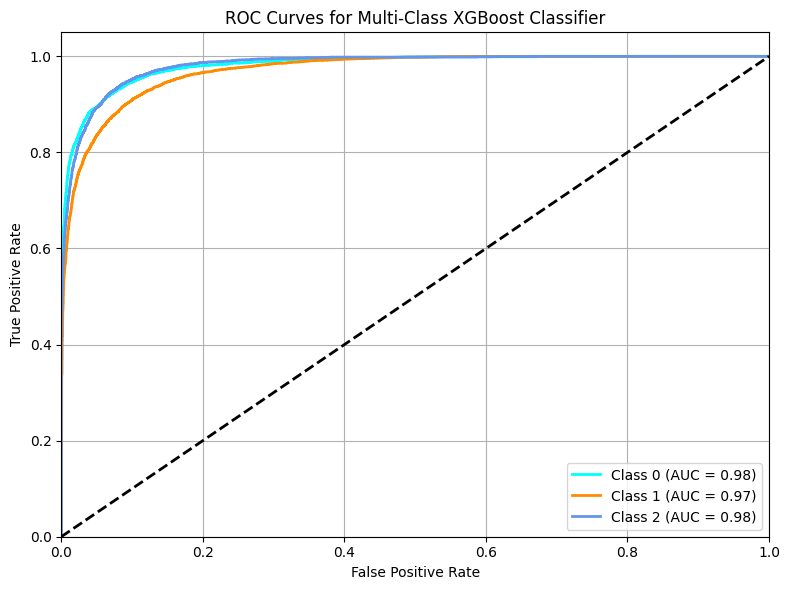

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class XGBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


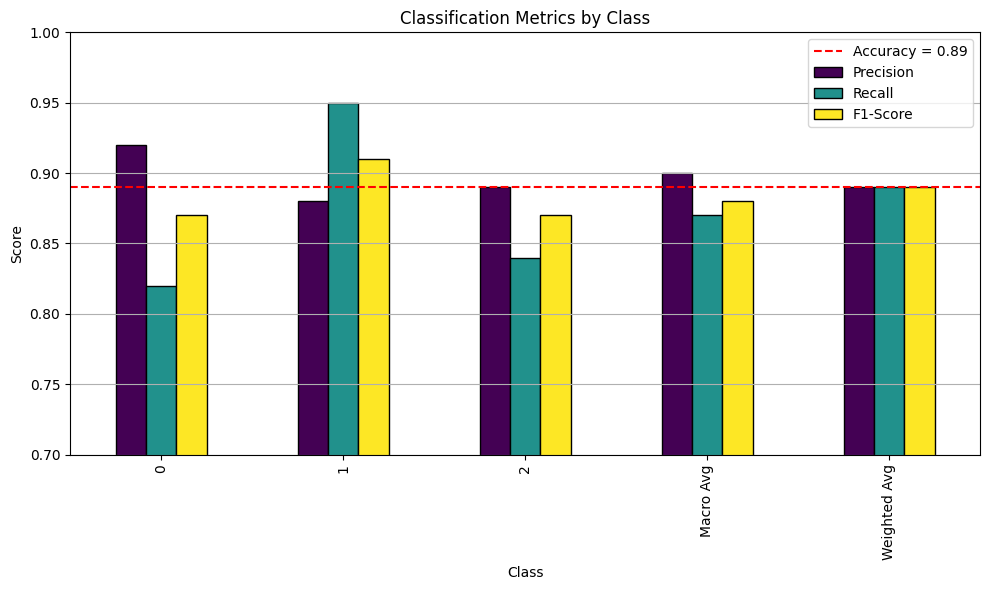

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

metrics = {
    'Class': ['0', '1', '2', 'Macro Avg', 'Weighted Avg'],
    'Precision': [0.92, 0.88, 0.89, 0.90, 0.89],
    'Recall':    [0.82, 0.95, 0.84, 0.87, 0.89],
    'F1-Score':  [0.87, 0.91, 0.87, 0.88, 0.89],
    'Support':   [3738, 9432, 4251, 17421, 17421]
}

df_metrics = pd.DataFrame(metrics)
df_metrics.set_index('Class', inplace=True)


accuracy = 0.89


ax = df_metrics[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(10, 6), colormap='viridis', edgecolor='black'
)
plt.axhline(y=accuracy, color='red', linestyle='--', linewidth=1.5, label=f'Accuracy = {accuracy:.2f}')
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.ylim(0.7, 1.0)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


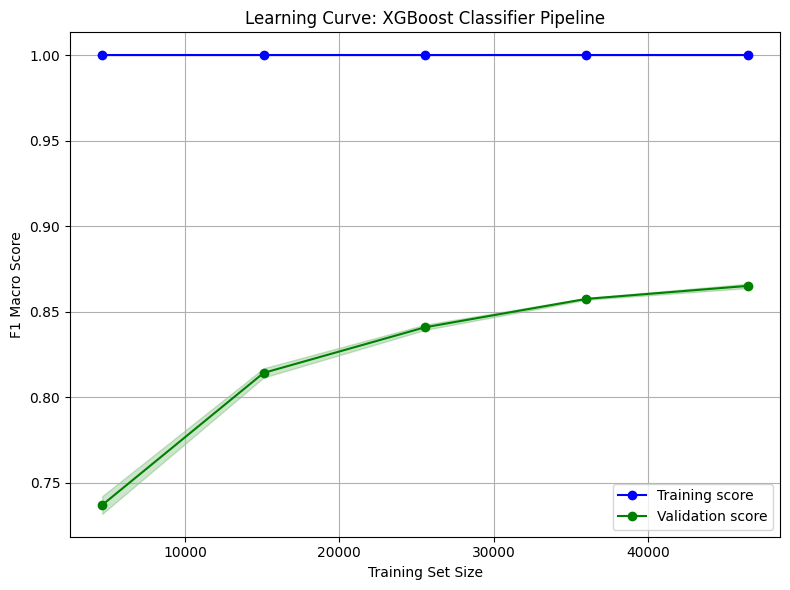

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
df_sensor['playYears'] = df_sensor['playYears'].astype(int)

X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']
classes = np.unique(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        num_class=3,
        random_state=42,
        n_jobs=-1,
        n_estimators=350,
        max_depth=15,
        learning_rate=0.3,
        subsample=1.0,
        colsample_bytree=0.8
    ))
])


def plot_learning_curve(estimator, X, y, cv=3, scoring='f1_macro', train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        train_sizes=train_sizes,
        shuffle=True,
        random_state=42
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, label="Training score", color="blue", marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    
    plt.plot(train_sizes, val_mean, label="Validation score", color="green", marker='o')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')
    
    plt.title("Learning Curve: XGBoost Classifier Pipeline")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Macro Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(pipeline, X_train, y_train, cv=3, scoring='f1_macro')

c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:18:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Paramet

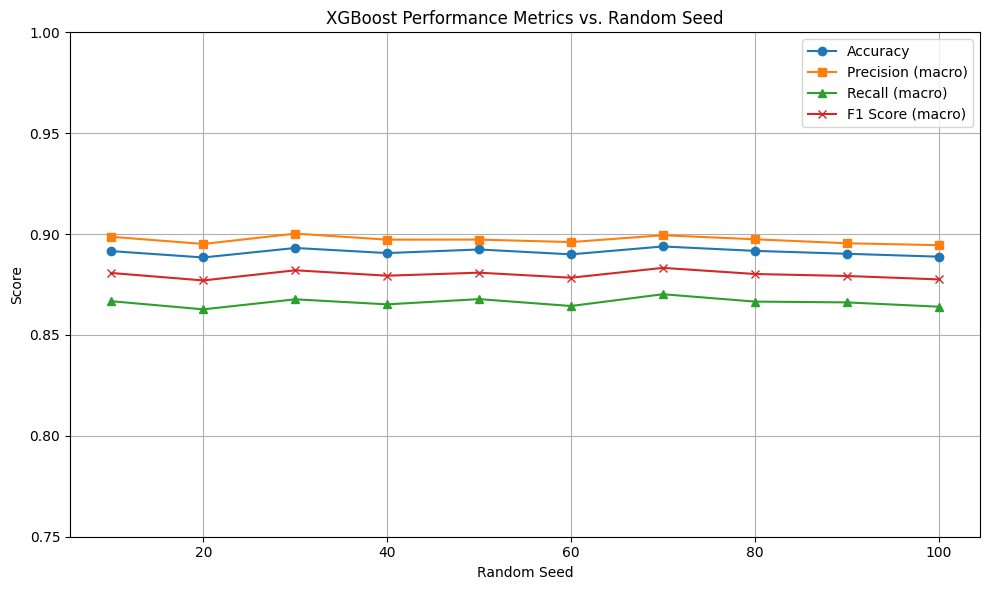

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']
classes = np.unique(y)


results = {
    'seed': [],
    'accuracy': [],
    'precision_macro': [],
    'recall_macro': [],
    'f1_macro': []
}


seeds = list(range(10, 110, 10))

for seed in seeds:

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )
    

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(
            n_estimators=350,
            max_depth=15,
            learning_rate=0.3,
            subsample=1.0,
            colsample_bytree=0.8,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=seed,
            n_jobs=-1
        ))
    ])
    

    pipeline.fit(X_train, y_train)
    

    y_pred = pipeline.predict(X_test)
    

    results['seed'].append(seed)
    results['accuracy'].append(accuracy_score(y_test, y_pred))
    results['precision_macro'].append(precision_score(y_test, y_pred, average='macro'))
    results['recall_macro'].append(recall_score(y_test, y_pred, average='macro'))
    results['f1_macro'].append(f1_score(y_test, y_pred, average='macro'))


df_results = pd.DataFrame(results)


plt.figure(figsize=(10, 6))
plt.plot(df_results['seed'], df_results['accuracy'], label='Accuracy', marker='o')
plt.plot(df_results['seed'], df_results['precision_macro'], label='Precision (macro)', marker='s')
plt.plot(df_results['seed'], df_results['recall_macro'], label='Recall (macro)', marker='^')
plt.plot(df_results['seed'], df_results['f1_macro'], label='F1 Score (macro)', marker='x')
plt.title("XGBoost Performance Metrics vs. Random Seed")
plt.xlabel("Random Seed")
plt.ylabel("Score")
plt.ylim(0.75, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:12:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:12:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:13:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:13:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Paramet

Top combinations by F1 Score:
   reg_alpha  reg_lambda  accuracy  precision_macro  recall_macro  f1_macro
2        0.0         4.0  0.892773         0.900021      0.868745  0.882663
5        0.1         0.1  0.893060         0.899542      0.868900  0.882593
1        0.0         1.0  0.892888         0.899722      0.868632  0.882524
7        0.1         4.0  0.892543         0.898960      0.869185  0.882508
3        0.0         7.0  0.892429         0.898977      0.868780  0.882282


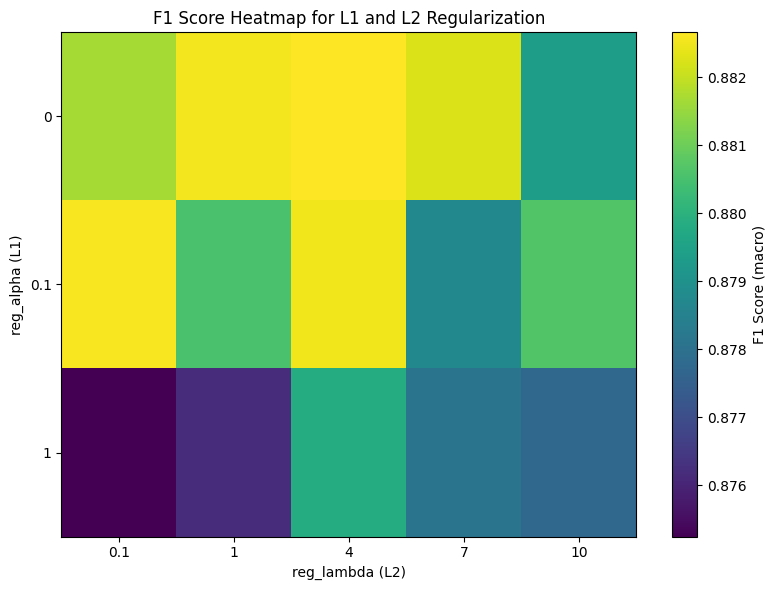

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']


seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed
)

reg_alpha_values = [0, 0.1, 1]
reg_lambda_values = [0.1, 1, 4, 7, 10]

# Store results
results = {
    'reg_alpha': [],
    'reg_lambda': [],
    'accuracy': [],
    'precision_macro': [],
    'recall_macro': [],
    'f1_macro': []
}

for reg_alpha in reg_alpha_values:
    for reg_lambda in reg_lambda_values:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('xgb', XGBClassifier(
                n_estimators=350,
                max_depth=15,
                learning_rate=0.3,
                subsample=1.0,
                colsample_bytree=0.8,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                use_label_encoder=False,
                eval_metric='mlogloss',
                random_state=seed,
                n_jobs=-1
            ))
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)


        results['reg_alpha'].append(reg_alpha)
        results['reg_lambda'].append(reg_lambda)
        results['accuracy'].append(accuracy_score(y_test, y_pred))
        results['precision_macro'].append(precision_score(y_test, y_pred, average='macro'))
        results['recall_macro'].append(recall_score(y_test, y_pred, average='macro'))
        results['f1_macro'].append(f1_score(y_test, y_pred, average='macro'))


df_results = pd.DataFrame(results)


print("Top combinations by F1 Score:")
print(df_results.sort_values(by='f1_macro', ascending=False).head())

pivot = df_results.pivot(index='reg_alpha', columns='reg_lambda', values='f1_macro')


plt.figure(figsize=(8, 6))
plt.imshow(pivot, cmap='viridis', aspect='auto')
plt.colorbar(label='F1 Score (macro)')
plt.xticks(ticks=np.arange(len(reg_lambda_values)), labels=reg_lambda_values)
plt.yticks(ticks=np.arange(len(reg_alpha_values)), labels=reg_alpha_values)
plt.xlabel('reg_lambda (L2)')
plt.ylabel('reg_alpha (L1)')
plt.title('F1 Score Heatmap for L1 and L2 Regularization')
plt.tight_layout()
plt.show()


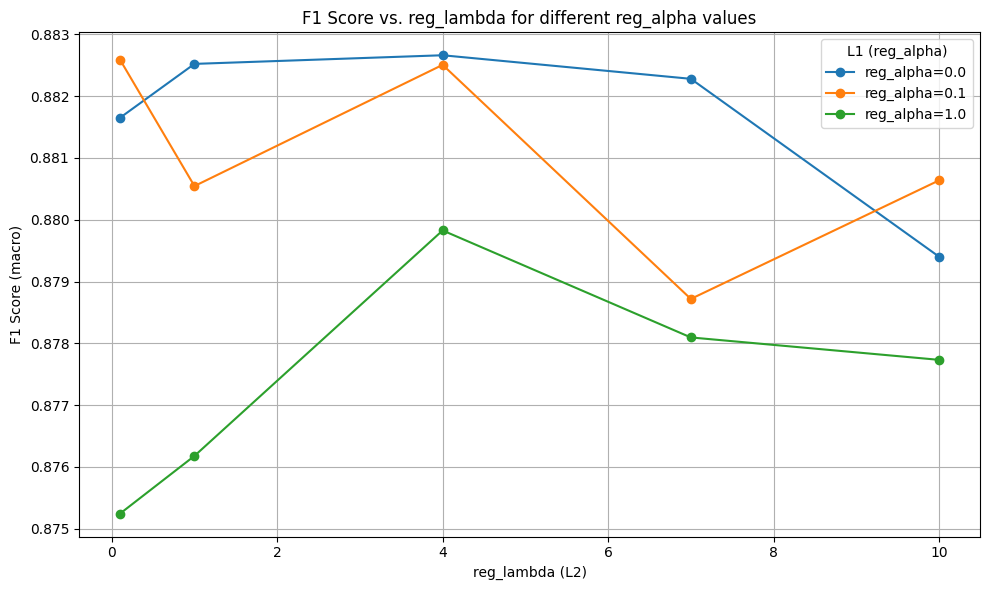

In [ ]:

plt.figure(figsize=(10, 6))

for reg_alpha in sorted(df_results['reg_alpha'].unique()):
    subset = df_results[df_results['reg_alpha'] == reg_alpha]
    plt.plot(subset['reg_lambda'], subset['f1_macro'], marker='o', label=f'reg_alpha={reg_alpha}')

plt.xlabel('reg_lambda (L2)')
plt.ylabel('F1 Score (macro)')
plt.title('F1 Score vs. reg_lambda for different reg_alpha values')
plt.grid(True)
plt.legend(title='L1 (reg_alpha)')
plt.tight_layout()
plt.show()
